## ML

##  Мультиклассовая классификация датасета флагов различных стран

### 1. Импорт библиотек / импорт и предобработка данных 

In [ ]:
import pandas as pd
import numpy as np
# import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, mean_squared_error, r2_score, accuracy_score,f1_score,precision_score,recall_score, confusion_matrix, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score

In [ ]:
cols = ['name','landmass','zone','area','population','language','religion','bars','stripes',
       'colours','red','green','blue','gold','white','black','orange','mainhue','circles',
       'crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate',
       'text','topleft','botright']

In [ ]:
data = pd.read_csv('flag.data',header=None,names=cols)
data.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


### 2. EDA

In [ ]:
pandas_profiling.ProfileReport(data)

C:\Users\admin\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,30
Number of observations,194
Total Missing (%),0.0%
Total size in memory,45.6 KiB
Average record size in memory,240.7 B
Numeric,13
Categorical,3
Boolean,13
Date,0
Text (Unique),1
Rejected,0


### 3. Feature Engeneering

#### 3.1. Цвет

Количество цветов флага по полю colours (от 1 до 8) не всегда совпадает с количеством указанных цветов по каждому из столбов (итого 7). Введем признак - "иной / неизвестный цвет",  тогда поле о количестве цветов окажется избыточным

In [ ]:
data.loc[(data.colours-data.red-data.green-data.blue-
          data.gold-data.white-data.black-data.orange)
          >0, 'other_colour']   = 1

In [ ]:
data.loc[data['other_colour'].isna(), 'other_colour'] = 0
data['other_colour']  = data['other_colour'].astype('int32')

#### 3.2. mainhue,  topleft,  botright

По сути эти поля только добавляют значимости каждому из полей цвета и не привносят дополнительной информации о составе цветов.  Для того, чтобы проще интерпретировать результаты анализа применим следующие допущения:

- признание цвета главным на флаге увеличивает его значимость в 2 раза (по сравнению с другими цветами флага)
- регистрация цвета в одном из углов флага добавляет акцент / + 10% значимости

да, это упрощение, да - можно все посчитать автоматически и посчитать насколько "главность" красного цвета отлична от "главности" синего цвета, но тогда нужно мудрить на стадиии feature impotance ^)

In [ ]:
k1 = 1
k2 = 0.1

In [ ]:
data.loc[data.mainhue  == 'red', 'red']                  = data['red'] + k1
data.loc[data.mainhue  == 'green', 'green']              = data['green'] + k1
data.loc[data.mainhue  == 'blue', 'blue']                = data['blue'] + k1
data.loc[data.mainhue  == 'gold', 'gold']                = data['gold'] + k1
data.loc[data.mainhue  == 'white', 'white']              = data['white'] + k1
data.loc[data.mainhue  == 'black', 'black']              = data['black'] + k1
data.loc[data.mainhue  == 'orange', 'orange']            = data['orange'] + k1
data.loc[data.mainhue  == 'other_colour','other_colour'] = data['other_colour'] + k1

In [ ]:
data.loc[data.topleft  == 'red', 'red']                  = data['red']   + k2
data.loc[data.topleft  == 'green', 'green']              = data['green'] + k2
data.loc[data.topleft  == 'blue', 'blue']                = data['blue']  + k2
data.loc[data.topleft  == 'gold', 'gold']                = data['gold']  + k2
data.loc[data.topleft  == 'white', 'white']              = data['white'] + k2
data.loc[data.topleft  == 'black', 'black']              = data['black'] + k2
data.loc[data.topleft  == 'orange', 'orange']            = data['orange']+ k2
data.loc[data.topleft  == 'other_colour','other_colour'] = data['other_colour'] + k2

In [ ]:
data.loc[data.botright  == 'red', 'red']                  = data['red']   + k2
data.loc[data.botright  == 'green', 'green']              = data['green'] + k2
data.loc[data.botright  == 'blue', 'blue']                = data['blue']  + k2
data.loc[data.botright  == 'gold', 'gold']                = data['gold']  + k2
data.loc[data.botright  == 'white', 'white']              = data['white'] + k2
data.loc[data.botright  == 'black', 'black']              = data['black'] + k2
data.loc[data.botright  == 'orange', 'orange']            = data['orange'] + k2
data.loc[data.botright  == 'other_colour','other_colour'] = data['other_colour'] + k2

In [ ]:
data_colours = data.iloc[:,[10,11,12,13,14,15,16,30]]
data_colours.head(1)

,red,green,blue,gold,white,black,orange,other_colour
0,1.0,2.1,0.0,1.0,1.0,1.1,0.0,0.0


#### 3.3. Рисунок флага

In [ ]:
data.iloc[:,[7,8,18,19,20,21,22,23,24,25,26,27]].describe().round(2)

,bars,stripes,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text
count,194.00,194.00,194.00,194.00,194.00,194.00,194.00,194.00,194.00,194.00,194.0,194.00
mean,0.45,1.55,0.17,0.15,0.09,0.15,1.39,0.06,0.14,0.25,0.2,0.08
std,1.04,2.33,0.46,0.39,0.29,0.44,4.40,0.23,0.35,0.44,0.4,0.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
75%,0.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.75,0.0,0.00
max,5.00,14.00,4.00,2.00,1.00,4.00,50.00,1.00,1.00,1.00,1.0,1.00


В отношении  элементов рисунка флага - stripes и sunstars, наверное без разницы 5 звезд или 50 звезд / их много

In [ ]:
data.sunstars.value_counts()
data.stripes.value_counts()

0     110
3      44
2      16
5      12
1       4
9       2
14      1
13      1
11      1
7       1
6       1
4       1
Name: stripes, dtype: int64

In [ ]:
data.loc[data.sunstars > 5, 'sunstars'] = 5
data.loc[data.stripes > 5,  'stripes']  = 5

In [ ]:
data.iloc[:,[7,8,18,19,20,21,22,23,24,25,26,27]].describe().round(2)

,bars,stripes,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text
count,194.00,194.00,194.00,194.00,194.00,194.00,194.00,194.00,194.00,194.00,194.0,194.00
mean,0.45,1.38,0.17,0.15,0.09,0.15,0.89,0.06,0.14,0.25,0.2,0.08
std,1.04,1.74,0.46,0.39,0.29,0.44,1.51,0.23,0.35,0.44,0.4,0.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
75%,0.00,3.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.75,0.0,0.00
max,5.00,5.00,4.00,2.00,1.00,4.00,5.00,1.00,1.00,1.00,1.0,1.00


In [ ]:
data_image = data.iloc[:,[7,8,18,19,20,21,22,23,24,25,26,27]]

#### 3.4. География

In [ ]:
data.iloc[:,[0,1,2,3,4,5]].head()

,name,landmass,zone,area,population,language
0,Afghanistan,5,1,648,16,10
1,Albania,3,1,29,3,6
2,Algeria,4,1,2388,20,8
3,American-Samoa,6,3,0,0,1
4,Andorra,3,1,0,0,6


показатели landmass и zone характеризуют геолокацию страны происхождения флага, причем в отношении каждой из стран структура значимости каждого из геопоказателей очень сильно разная. Для простоты интерпретации сформируем один геопоказатель на основе 2

In [ ]:
data[data.landmass==6].zone.value_counts()

2    10
3     5
1     5
Name: zone, dtype: int64

In [ ]:
data['geo_zone'] = data.landmass.astype(str).str.cat(data.zone.astype(str), sep =" ") 

data['geo_zone'].value_counts()

5 1    39
1 4    31
3 1    28
4 2    19
4 1    19
4 4    13
6 2    10
2 3    10
2 4     7
3 4     7
6 3     5
6 1     5
4 3     1
Name: geo_zone, dtype: int64

В отношении площади и населения в помощь - MinMaxScaler

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
data['area'] = min_max_scaler.fit_transform(np.array(data['area']).reshape(-1, 1))
data['population'] = min_max_scaler.fit_transform(np.array(data['population']).reshape(-1, 1))

In [ ]:
data.iloc[:,[3,4]]

,area,population
0,-0.942148,-0.968254
1,-0.997411,-0.994048
2,-0.786805,-0.960317
3,-1.000000,-1.000000
4,-1.000000,-1.000000
...,...,...
189,-0.999732,-1.000000
190,-0.977145,-0.956349
191,-0.919204,-0.944444
192,-0.932774,-0.988095


In [ ]:
data_geo = pd.concat([data.iloc[:,[3,4]],
                      pd.get_dummies(data.iloc[:,[5,31]].astype(object)),
                     ], axis=1)
data_geo.head(1)

,area,population,language_1,language_2,language_3,language_4,language_5,language_6,language_7,language_8,...,geo_zone_3 1,geo_zone_3 4,geo_zone_4 1,geo_zone_4 2,geo_zone_4 3,geo_zone_4 4,geo_zone_5 1,geo_zone_6 1,geo_zone_6 2,geo_zone_6 3
0,-0.942148,-0.968254,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
data_a =  pd.concat([
                     data_colours,
                     data_image, 
                     data_geo], 
                     axis=1)

### 4. Feature importances

#### 4.1. Базовая функция расчета и визуализации показателей значимости признаков

In [ ]:
def feature_report (xx, limit):
    output_y = data['religion']
    input_x  = xx
    le=LabelEncoder()
    targets=(output_y==1)
    Y= le.fit_transform(targets)
    x_train, x_test, y_train, y_test = train_test_split(input_x, 
                                                        Y, 
                                                        test_size = 0.2, 
                                                        random_state = 100)
    model=RandomForestClassifier(max_depth=20,min_samples_leaf=5,n_estimators=1000,n_jobs=-1,random_state=42)
    model.fit(x_train,y_train)
    model_pred = model.predict(x_test)
    print(classification_report(y_test, model_pred))
    print('точность предсказания модели составила: ', 
          (100*model.score(x_test, y_test)).round(3),
           'процентов')
    
    # формируем рэнкинг параметров 
    headers = list(input_x.columns.values)
    feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)[:limit]
    f, ax = plt.subplots(figsize=(6, 6))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Уровень значимости параметров')
    plt.ylabel('Параметры')
    plt.title('Рэнкинг значимости параметров')
    plt.show()

#### 4.2. Feature importances по всем признакам датасета

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        25
           1       1.00      0.64      0.78        14

    accuracy                           0.87        39
   macro avg       0.92      0.82      0.85        39
weighted avg       0.89      0.87      0.86        39

точность предсказания модели составила:  87.179 процентов


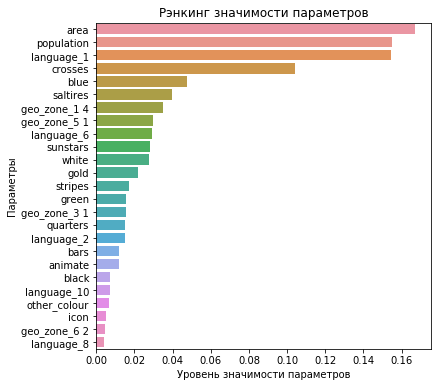

In [ ]:
feature_report (data_a.iloc[:,1:], 25)

(20.0, 0.0)

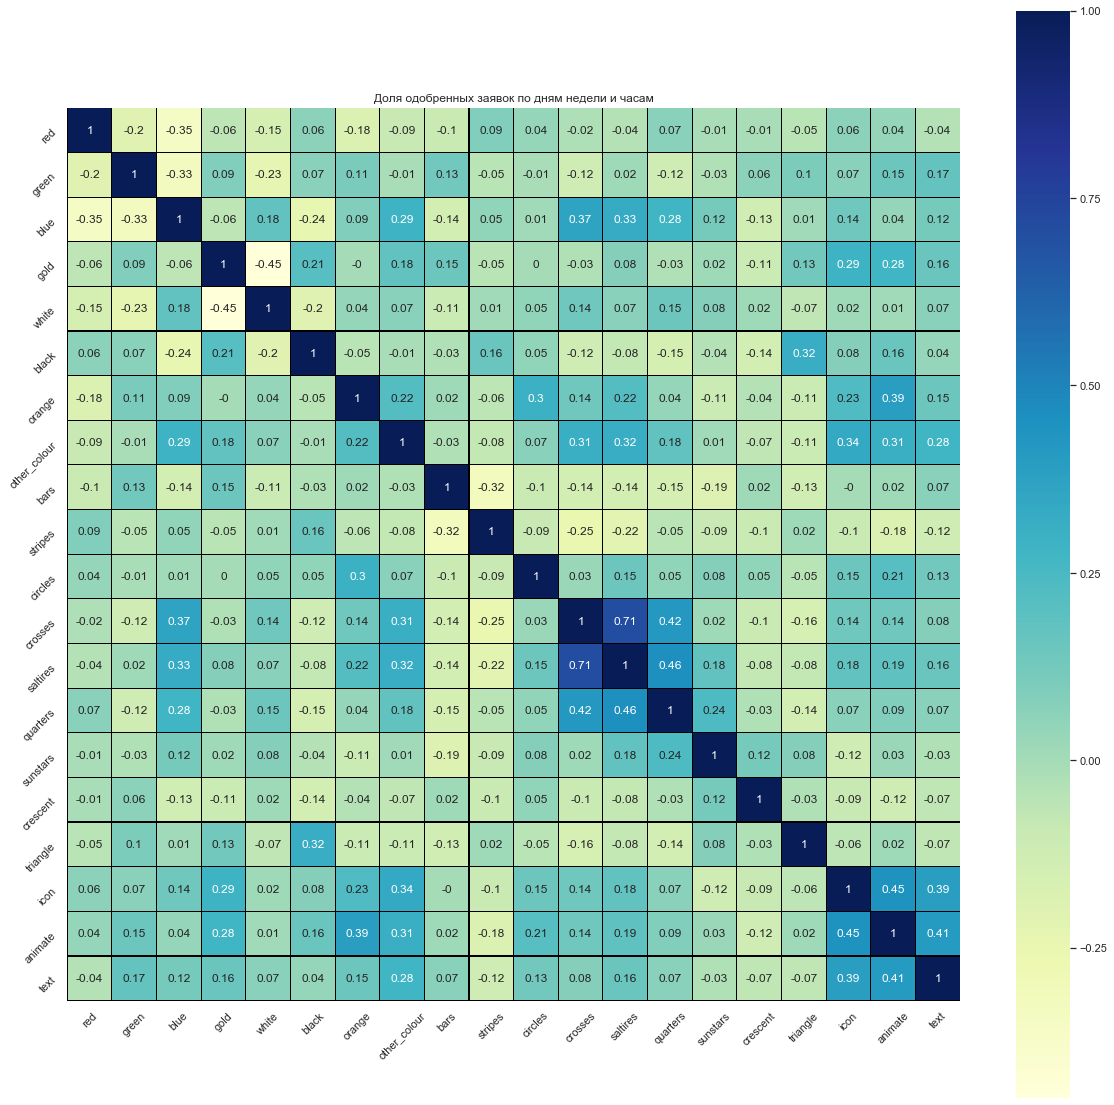

In [ ]:
# матрица корреляций по метрикам цвета и рисунка флага

sns.set(rc={'figure.figsize':(20,20)})
ax = sns.heatmap(pd.concat([data_colours, data_image], axis=1).corr().round(2),  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)

plt.title('Доля одобренных заявок по дням недели и часам')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

(33.0, 0.0)

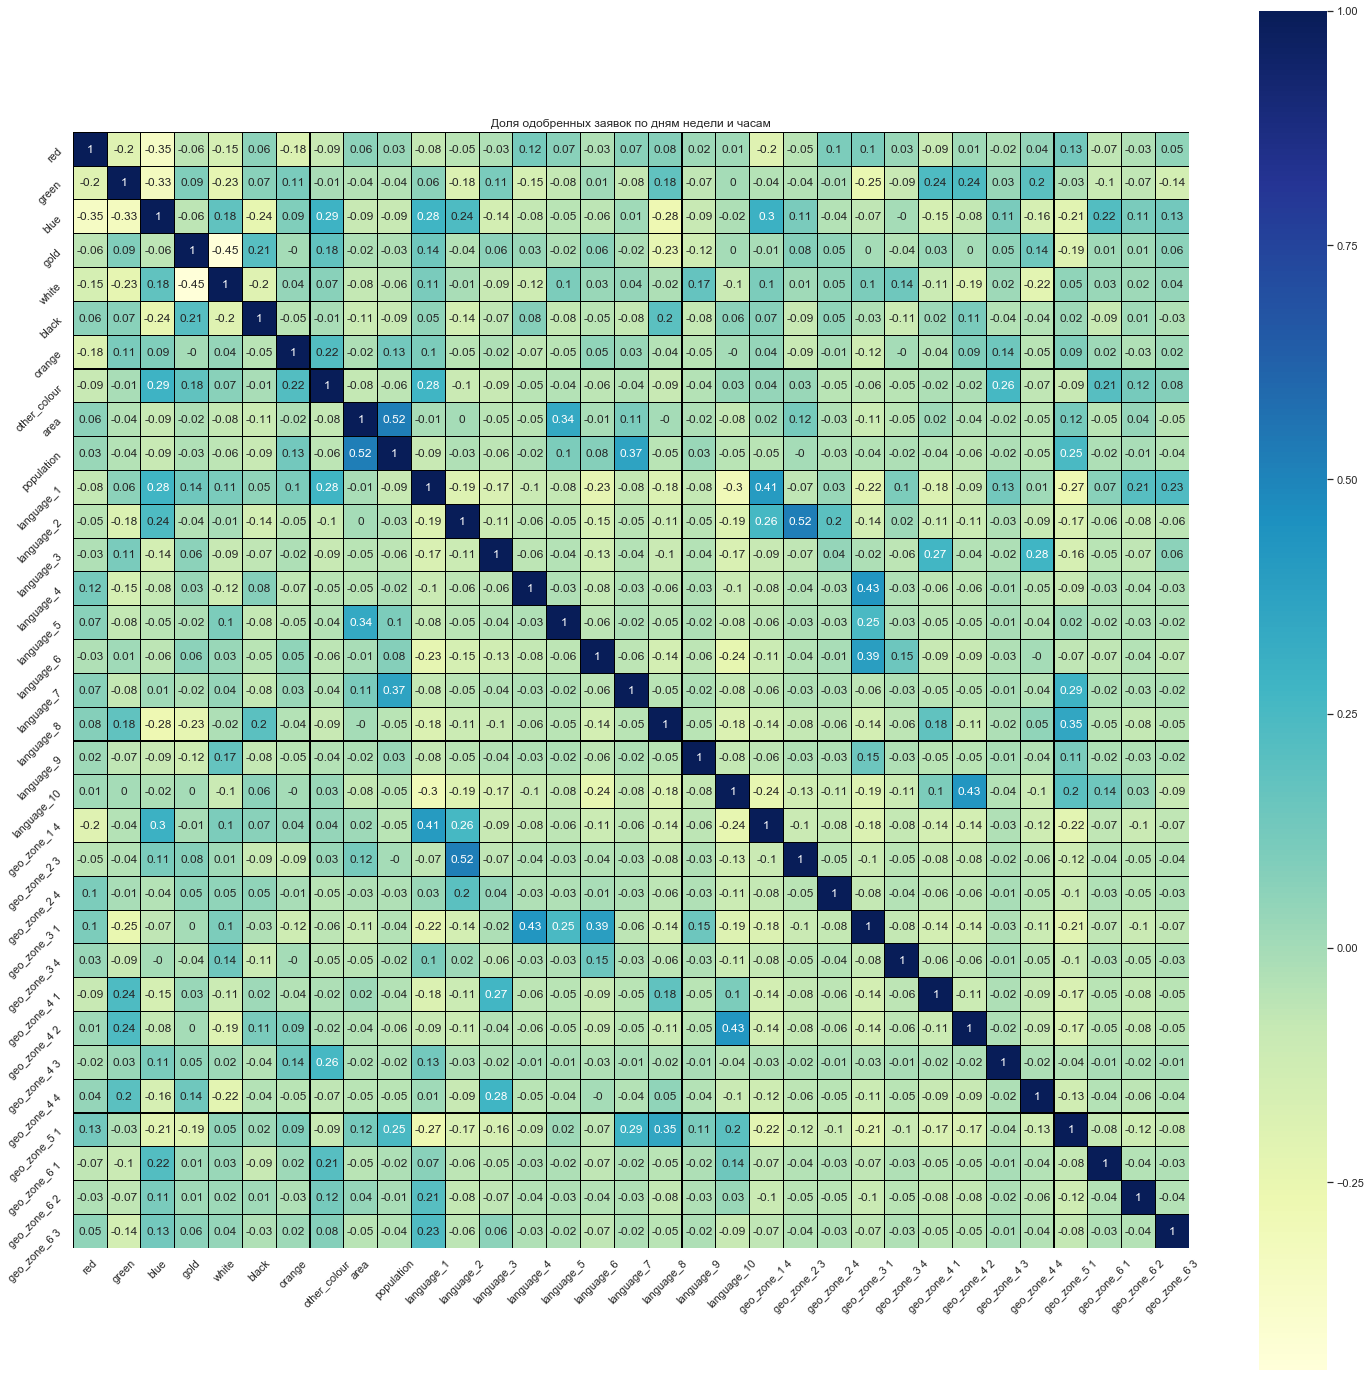

In [ ]:
# матрица корреляций по метрикам цвета и характеристик страны флага

sns.set(rc={'figure.figsize':(25,25)})
ax = sns.heatmap(pd.concat([data_colours, data_geo], axis=1).corr().round(2),  
                annot = True, 
                fmt='.2g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)

plt.title('Доля одобренных заявок по дням недели и часам')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

#### 4.3. Feature importances только по признакам цвета и рисунка флага

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        25
           1       1.00      0.29      0.44        14

    accuracy                           0.74        39
   macro avg       0.86      0.64      0.64        39
weighted avg       0.82      0.74      0.69        39

точность предсказания модели составила:  74.359 процентов


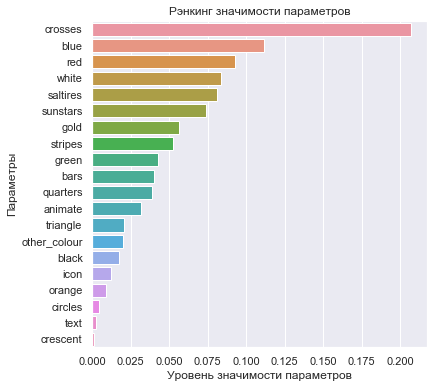

In [ ]:
feature_report (pd.concat([data_colours, data_image], axis=1), 25)

### 5. Кросс валидация

In [ ]:
def cross_valid (model, metric):
    skf = KFold(n_splits=3, random_state=None, shuffle=False)
    train_metric, test_metric = [], []
    for train_index, test_index in skf.split(x, Y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        model.fit(x_train, y_train)
        y_pred_train, y_pred_test = model.predict(x_train), model.predict(x_test)
        train_metric.append(metric(y_train, y_pred_train))
        test_metric.append (metric(y_test, y_pred_test))
    print(model)
    print('model.score = ', model.score(x_test,y_test))
    print('train metric after cross val = ',  round(sum(train_metric)/len(train_metric),5))
    print('test  metric after cross val = ',  round(sum(test_metric)/len(test_metric),5))
    
    

In [ ]:
x  = data_a
Y  = data['religion']
cross_valid  (model = RandomForestClassifier
             (max_depth=20,min_samples_leaf=5,n_estimators=1000,n_jobs=-1,random_state=42),
              metric = mean_squared_error)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=1000,
                       n_jobs=-1, random_state=42)
model.score =  0.671875
train metric after cross val =  2.76702
test  metric after cross val =  4.23101


### 6. Изменение размерности / PCA

In [ ]:
from sklearn.decomposition import PCA
X_pca = pd.DataFrame(PCA(n_components=5).fit_transform(x))

In [ ]:
for trn_idx,tst_idx in sss.split(X_pca,Y):
    X_train_pca,y_train_pca = X_pca.iloc[trn_idx],Y.iloc[trn_idx]
    X_test_pca,y_test_pca   = X_pca.iloc[tst_idx],Y.iloc[tst_idx]

In [ ]:
rfc = RandomForestClassifier(max_depth=20,min_samples_leaf=5,n_estimators=100,n_jobs=-1,random_state=42)

score_on_train = 0

for trn_idx,tst_idx in KFold(n_splits=3,random_state=42).split(X_train_pca,y_train_pca):
    X_train_fold,y_train_fold = X_pca.iloc[trn_idx],Y.iloc[trn_idx]
    X_test_fold,y_test_fold   = X_pca.iloc[tst_idx],Y.iloc[tst_idx]
    
    rfc.fit(X_train_fold,y_train_fold)
    score_on_train           += rfc.score(X_test_fold,y_test_fold)

rfc.fit(X_train_pca,y_train_pca)

print ('model.score = ', rfc.score(X_test_pca,y_test_pca))

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


model.score =  0.5128205128205128


Понижение размерности методом PCA оказалось неэффективно

### 7. Балансирование классов

In [ ]:
classes_count   = Y.value_counts()
max_class_count = classes_count.max()

X_over = x.copy()
y_over = Y.copy()

In [ ]:
for cls in zip(classes_count,classes_count.index):
    if cls[0] != max_class_count:
        idx = np.random.choice(Y[Y==cls[1]].index,size = max_class_count-cls[0])
        X_add = x.iloc[idx]
        y_add = Y.iloc[idx]
        X_over = X_over.append(X_add)
        y_over = y_over.append(y_add)

In [ ]:
rfc = RandomForestClassifier(max_depth=20,
                             min_samples_leaf=5,
                             n_estimators=100,
                             n_jobs=-1,
                             random_state=42)

score_on_train = 0

for trn_idx,tst_idx in KFold(n_splits=3,random_state=42).split(X_train_over,y_train_over):
    X_train_fold,y_train_fold = X_over.iloc[trn_idx],y_over.iloc[trn_idx]
    X_test_fold,y_test_fold = X_over.iloc[tst_idx],y_over.iloc[tst_idx]
    rfc.fit(X_train_fold,y_train_fold)
    score_on_train += rfc.score(X_test_fold,y_test_fold)

rfc.fit(X_train_over,y_train_over)

print('model.score = ', rfc.score(X_test_over,y_test_over))

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


model.score =  0.84375


In [ ]:
X_train_over,X_test_over,y_train_over,y_test_over=train_test_split(X_over,
                                                                   y_over,
                                                                   test_size=.2, 
                                                                   random_state=42)

Балансирование классов привело к увеличению информативности модели

### 8. Мультиклассовая классификация / предсказание религии страны  по деталям флага и геометрикам 

In [ ]:
params = {'n_estimators':    [10,20,30,40,50,60,70, 80,90, 100, 1000],
          'max_depth':       [5,6,7,8,9,10,11,12,13,14,15],
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
          'random_state':    [50],
          'n_jobs':          [-1]}

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=1,n_jobs=-1,cv=3)
rf_grid.fit(X_train_over,y_train_over)

Fitting 3 folds for each of 1210 candidates, totalling 3630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3630 out of 3630 | elapsed:  5.7min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 1000],
                         'n_jobs': [-1], 'random_state': [50]},
             verbose=1)

In [ ]:
rf_grid.best_params_

{'max_depth': 15,
 'min_samples_leaf': 1,
 'n_estimators': 1000,
 'n_jobs': -1,
 'random_state': 50}

In [ ]:
print('Random Forest model.score = ', rf_grid.score(X_test_over,y_test_over))

Random Forest model.score =  0.90625


In [ ]:
from sklearn.linear_model import LogisticRegression
params = {'penalty':['l2'],
          'max_iter':[100,500,1000],
          'multi_class':['multinomial'],
          'n_jobs':[-1],
          'C':[0.01,0.1,0.5,1.0],
          'solver':['newton-cg','sag','saga','lbfgs']}
lr_grid = GridSearchCV(LogisticRegression(),param_grid=params,verbose=1,n_jobs=-1,cv=3)
lr_grid.fit(X_train_over,y_train_over)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    5.4s finished


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1.0],
                         'max_iter': [100, 500, 1000],
                         'multi_class': ['multinomial'], 'n_jobs': [-1],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
             verbose=1)

In [ ]:
print('LogisticRegression model.score = ', lr_grid.score(X_test_over,y_test_over))

LogisticRegression model.score =  0.8020833333333334


Random Forest и на этот раз показал лучшие результаты. ожидаемо,  


но хочется много лучше

In [ ]:
St_classifier = StackingClassifier(
    [
        ('lr', lr_grid),
        ('rf', rf_grid),
        ('kn', KNeighborsClassifier())
    ],
LogisticRegression())

In [ ]:
St_classifier.fit(X_train_over,y_train_over)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1210 candidates, totalling 3630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3630 out of 3630 | elapsed:  5.6min finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1210 candidates, totalling 3630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3630 out of 3630 | elapsed:  5.5min finished


Fitting 3 folds for each of 1210 candidates, totalling 3630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3630 out of 3630 | elapsed:  5.6min finished


Fitting 3 folds for each of 1210 candidates, totalling 3630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3630 out of 3630 | elapsed:  5.6min finished


Fitting 3 folds for each of 1210 candidates, totalling 3630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3630 out of 3630 | elapsed:  5.5min finished


Fitting 3 folds for each of 1210 candidates, totalling 3630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3630 out of 3630 | elapsed:  5.6min finished


StackingClassifier(estimators=[('lr',
                                GridSearchCV(cv=3,
                                             estimator=LogisticRegression(),
                                             n_jobs=-1,
                                             param_grid={'C': [0.01, 0.1, 0.5,
                                                               1.0],
                                                         'max_iter': [100, 500,
                                                                      1000],
                                                         'multi_class': ['multinomial'],
                                                         'n_jobs': [-1],
                                                         'penalty': ['l2'],
                                                         'solver': ['newton-cg',
                                                                    'sag',
                                                                    'saga',
   

### 9. Проверка качества классификации с использованием метрик: Accuracy, F1-Score, Precision, Recall

In [ ]:
print(classification_report(y_test_over,st_pred))
print('точность предсказания модели составила: ',(100*St_classifier.score(X_test_over, y_test_over)).round(3), '%')

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.93      0.87      0.90        15
           2       0.82      0.69      0.75        13
           3       0.91      1.00      0.95        10
           4       0.93      1.00      0.97        14
           5       0.80      0.89      0.84         9
           6       0.91      1.00      0.95        10
           7       1.00      1.00      1.00        15

    accuracy                           0.92        96
   macro avg       0.91      0.92      0.91        96
weighted avg       0.92      0.92      0.91        96

точность предсказания модели составила:  91.667 %


### 10. Confusion Matrix 

In [ ]:
confusion_matrix(y_test_over,st_pred)

array([[ 9,  0,  0,  0,  0,  0,  1,  0],
       [ 0, 13,  1,  0,  1,  0,  0,  0],
       [ 0,  1,  9,  1,  0,  2,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 15]], dtype=int64)